# Solar PV Feasibility Study

. Solar PV array: A large solar photo voltaic array
- (a) The array, including all inverter and connection equipment, will cost $1.09 per W (AC)
capacity.1
- (b) The array will be made of state-of-the-art Panasonic HIT PV module N330E series (see
the spec. sheet on the Brightspace or nd it online from manufacturer)
- (c) The solar array is tilted at xed angle of latitude of Burlington (L = Σ = 44.5 degrees)
and due south (φC = 0)
- i. See the solar data on Brightspace. We are interested in METSTAT values and our
lecture notes for calculations. Assume the following:
- 1For a good discussion of PV system costs see: https://www.nrel.gov/docs/fy22osti/80694.pdf .

- A. METSTAT Dir (W/m^2) = IB
- B. METSTAT Dif (W/m^2) = IDH
- C. Use IB and IDH and your notes to calculate the reected radiation on the collector IRC
- D. From the three collector insolations, use Solar PV specs and your knowledge of
PV energy systems to calculate AC power output. Feel free to assume that a
PV inverter has 97 % eciency or nd another PV inverter online and cite it.
- (d) The investor may be able to obtain tax credits to oset the cost of the plant. She may
also be able to sell renewable energy credits in the New England market, once the plant
is operating.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.interpolate import interp1d

Notes:
- sum of 3 components of radiation (total radiation)
- ignore degradation. instead, annual value just repeats 20 times
- section 3, question 4 IGNORE cause it's about the metstat file we're not using
- question 3: just do the first plot for the first 48 hrs
- panel specs

key for csv data:
- Gb(i): Beam (direct) irradiance on the inclined plane (plane of the array) (W/m2)	
- Gd(i): Diffuse irradiance on the inclined plane (plane of the array) (W/m2)	
- Gr(i): Reflected irradiance on the inclined plane (plane of the array) (W/m2)	
- H_sun: Sun height (degree)	
- T2m: 2-m air temperature (degree Celsius)	
- WS10m: 10-m total wind speed (m/s)	
- Int: 1 means solar radiation values are reconstructed	
	
PVGIS (c) European Union	2001-2025

In [21]:
# read data files
# read data
df = pd.read_csv("./Timeseries_44.500_-73.200_E5_44deg_0deg_2022_2022.csv")
df2 = pd.read_csv("../L04/vermont_demand_price_2022.csv")

# Extract data
gbi = df["Gb(i)"]
gdi = df["Gd(i)"]
gri = df["Gr(i)"]
df['i_tot'] = df["Gb(i)"] + df["Gd(i)"] + df["Gr(i)"] # total irradiance W/m^2

price_per_MWh = df2["Price ($/MWh)"]
load_MW = df2["Load (MW)"]

In [22]:
# panel plus inverter specs
e_inverter = .97 # inverter efficiency
a_per_mod = 1.67 # m^2 area per panel
e_per_mod = .199 # efficiency per panel
pmax_dc = 330 # W DC
pmax_ac = pmax_dc * e_inverter # 320 W ac

# only dispatch if PRICE IS GREATER THAN ZERO TODO IMPLEMENT THIS CONDITION IN CODE TO CALCULATE NUMBER OF PANELS
# NEED SLIGHTLY MORE PANELS THAN CURRENTLY CALCULATED
def dispatch_factor(p):
    if p == 0 
        return 0
    if p > 0 
        return 1

# STC  is 1000 W/m^2
# DC power per panel at each hour (scale STC rating by irradiance / 1000)
df['P_dc_per_panel_W'] = pmax_dc * (df['i_tot'] / 1000)

# AC power after inverter and clipping to AC max
df['P_ac_per_panel_W'] = np.minimum(df['P_dc_per_panel_W'] * e_inverter, pmax_ac)

# W * hr * convert to MW
annual_energy_per_panel_MWh = df['P_ac_per_panel_W'].sum() / 1e6

target_annual_MWh = 438000 # MWh/year target 50*8760
num_panels = math.ceil(target_annual_MWh / annual_energy_per_panel_MWh)

# Installed capacities
installed_capacity_dc_MW = num_panels * pmax_dc / 1e6
installed_capacity_ac_MW = num_panels * pmax_ac / 1e6

print(f"Annual energy per panel: {annual_energy_per_panel_MWh:.3f} MWh")
print(f"Panels needed: {num_panels:,d}")
print(f"Installed DC capacity: {installed_capacity_dc_MW:.2f} MW")
print(f"Installed AC capacity: {installed_capacity_ac_MW:.2f} MW")

Annual energy per panel: 0.534 MWh
Panels needed: 819,703
Installed DC capacity: 270.50 MW
Installed AC capacity: 262.39 MW


In [17]:
# capacity factor
# capacity factor (actual energy out / possible energy out)
# dispatch rule is when market price is > 0

energy_produced =  df['P_ac_per_panel_W'].sum() * num_panels / 1e6 # MWh generated by PV farm
total_energy = installed_capacity_ac_MW * 8760 # MWh capacity
cf = energy_produced / total_energy
print("capacity factor:  ", cf)

capacity factor:   0.19055847260273978


In [31]:
# num hours in which pp will produce nonzero energy 

# revenue
rev = 0
for h in range(8760):
    if df['P_ac_per_panel_W'].iloc[h] > 0:
        rev += df['P_ac_per_panel_W'].iloc[h] * num_panels / 1e6 * price_per_MWh[h]

print("rev: $", f"${rev:,.2f}")

# costs

# Solar PV O&M = $14.61/kW (DC) capacity / year (NREL)
om_per_year = 14.61 * 1e3 * installed_capacity_dc_MW
print("om per year: ", f"${om_per_year:,.2f}")

# startup costs
# $1.09 per W (AC)
P = 1.09 * installed_capacity_ac_MW * 1e6

# annual payment
n = 20
r = .05
rn = (1+r) ** n

A = P * r * rn / (rn -1)
print("Annual cost of capital for loan: $", f"${A:,.2f}")

rev: $ $41,841,309.16
om per year:  $3,952,034.07
Annual cost of capital for loan: $ $22,949,520.68


## For each power plant

For each power plant calculate the following:
1. Calculate the size (capacity) of the plant that is needed to ensure that it produces an average
of 50 MW (electricity, ignore station service power) per year.
    - panels needed 819703 panels. Installed DC capacity is 270 MW (AC is 262 MW)
3. Compute the capacity factor for the power plant using total energy produced vs. total energy if asset was producing at rated capacity all year long.
    - cf = .19055
5. Using appropriate plant dispatch rules, Compute the number of hours in which the power
plant will produce a non-zero amount of energy (i.e., plant is dispatched: ON and MW>0),
given the prices of electricity and other factors, such as steam revenue and O&M costs (see
below).
6. Calculate the 1-year revenue earned by selling electricity, heat and/or renewable energy credits
at given/current market prices.
     - rev \\$41,841,309.16
8. Estimate the annual operating and fuel costs for the plant, over a 20 year planning horizon.
For each plant, assume that operations and maintenance (O&M) costs are currently
    - (a) for Solar PV O&M = 14.61/kW (DC) capacity / year (NREL)
    - ~~i. Assume performance degradation of 0.26% per year in kWh output (or see spec
sheet) .~~
    - om per year: 3,952,034.07
9. Calculate the annual cost of capital (i.e., the loan), assuming that capital is available for the
project at a 5% interest rate, for a 20 year planning horizon. To do this calculation use the
P to A equation
assume that the bond (loan) for this project is spread over a 20 year period. In the equation
above A is the annual cost of capital, P is the principle of the loan, r is the interest rate, and
n is the number of periods (20).
    - A = 22,949,520.68
11. For wind and solar, do a bit of research about other potential sources of revenue, or other ways
to reduce the cost. Things to look for are production tax credits, renewable energy credits,
or investment tax credits. Include these revenues/credits in your annual revenue projections
for the 20 year period [remember to include sources].
(a) For example, see NREL-funded incentives database DSIRE

In [1]:
# yeah

## 20-year outlook

In [32]:
# yeah
# inflation rates
power_inflation = .03
om_inflation = .025

years = range(1, 21) # 20 year outlook
rows = []
for y in years:
    om_cost = om_per_year * (1 + om_inflation) ** (y-1)
    capital_payment = A  # same each year

    total_rev = rev * (1 + power_inflation) ** (y-1)
    total_cost = om_cost + capital_payment
    
    net = total_rev - total_cost

    rows.append({
        "Year": y,
        "O&M Cost ($) ": f"{om_cost:,.2f}",
        "Annuity Payment ($)": f"{capital_payment:,.2f}",
        "TotalCost ($)": f"{total_cost:,.2f}",
        "Total Rev ($)": f"{total_rev:,.2f}",
        "Net ($)": f"{net:,.2f}"
    })

df_20yrs = pd.DataFrame(rows)

print(df_20yrs)
df_20yrs.to_csv('20-year-table.csv', index=False)

    Year O&M Cost ($)  Annuity Payment ($)  TotalCost ($)  Total Rev ($)  \
0      1  3,952,034.07       22,949,520.68  26,901,554.76  41,841,309.16   
1      2  4,050,834.93       22,949,520.68  27,000,355.61  43,096,548.43   
2      3  4,152,105.80       22,949,520.68  27,101,626.48  44,389,444.88   
3      4  4,255,908.44       22,949,520.68  27,205,429.13  45,721,128.23   
4      5  4,362,306.15       22,949,520.68  27,311,826.84  47,092,762.08   
5      6  4,471,363.81       22,949,520.68  27,420,884.49  48,505,544.94   
6      7  4,583,147.90       22,949,520.68  27,532,668.59  49,960,711.29   
7      8  4,697,726.60       22,949,520.68  27,647,247.29  51,459,532.63   
8      9  4,815,169.77       22,949,520.68  27,764,690.45  53,003,318.60   
9     10  4,935,549.01       22,949,520.68  27,885,069.70  54,593,418.16   
10    11  5,058,937.74       22,949,520.68  28,008,458.42  56,231,220.71   
11    12  5,185,411.18       22,949,520.68  28,134,931.86  57,918,157.33   
12    13  5,

## Solar PV specifc requirements:

For the solar PV plant calculate the following:
1. The area covered by the solar panels. Remember that a 1 m2
solar panel with a 100% eciency
will produce IC = IBC + IDC + IRC Watts. This will be used to estimate the amount of land
that will need to be purchased. Report your result in acres.
2. Plot the solar energy production (MW) over time for the first 48 hour period in the data
~~and hours 4368 to 4415.~~
4. Calculate the average solar energy produced per day for each month of the year. Produce a
plot for this result.
5. Sensitivity study: repeat all solar calculations with METSTAT CSKY (clear sky model data)
- (a) Compare and contrast the results with METSTAT (cloudy) data.
i. Talk about the difference between the results from using the two solar sets
- (b) Based your (final) recommendation on just the METSTAT results.

In [35]:
# area covered by panels
m2_to_acres = 0.000247105

total_area_ac = num_panels * a_per_mod * m2_to_acres
print(total_area_ac, " acres")

338.26302539105  acres


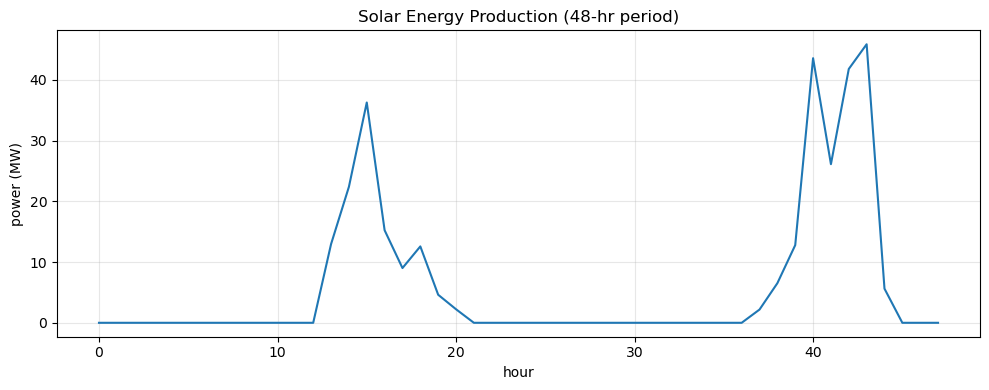

In [38]:
# plot solar energy production MW over the first 48 hour period in the data

# Total farm AC output in MW (W → MW)
df['farm_ac_MW'] = df['P_ac_per_panel_W'] * num_panels / 1e6

# Plot first 48 hours
plt.figure(figsize=(10, 4))
plt.plot(df['farm_ac_MW'].iloc[:48], label='solar farm output')
plt.title("Solar Energy Production (48-hr period)")
plt.xlabel("hour")
plt.ylabel("power (MW)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
